## Network Analysis

This notebook aims to visualize the relationship that exists within the anime studios, the anime staff, and tags for each title.

In [2]:
# !pip install nx_altair

In [26]:
import numpy as np
import pandas as pd
import altair as alt
import networkx as nx
import nx_altair as nxa
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
import itertools

In [3]:
# load
df_studios = pd.read_csv("../assets/studios_200p.csv")
df_staff = pd.read_csv("../assets/staff_200p.csv")
df_tags = pd.read_csv("../assets/tags_200p.csv")

In [4]:
display(df_studios.head(20))

,title_id,title_english,title_romaji,studio_id,studio_name
0,114129,Gintama: THE VERY FINAL,Gintama: THE FINAL,6116,Bandai Namco Pictures
1,114129,Gintama: THE VERY FINAL,Gintama: THE FINAL,6570,Shueisha
2,114129,Gintama: THE VERY FINAL,Gintama: THE FINAL,17,Aniplex
3,114129,Gintama: THE VERY FINAL,Gintama: THE FINAL,415,Warner Bros. Japan
4,114129,Gintama: THE VERY FINAL,Gintama: THE FINAL,53,Dentsu
5,114129,Gintama: THE VERY FINAL,Gintama: THE FINAL,16,TV Tokyo
6,124194,Fruits Basket The Final Season,Fruits Basket: The Final,73,TMS Entertainment
7,124194,Fruits Basket The Final Season,Fruits Basket: The Final,6663,TMS Music
8,124194,Fruits Basket The Final Season,Fruits Basket: The Final,102,Funimation
9,124194,Fruits Basket The Final Season,Fruits Basket: The Final,6429,Avex Pictures


In [5]:
print("total rows: ", len(df_studios), len(df_staff))
print("unique title counts: ", len(df_studios["title_romaji"].unique()), len(df_staff["title_romaji"].unique()))

# There are duplicate rows for each title: for example, "Shinji Takeuchi" appears twice for title "Gintama: THE FINAL"
df_staff_clean = df_staff.drop_duplicates(["title_romaji", "staff_name"])
df_studios_clean = df_studios.drop_duplicates(["title_romaji", "studio_name"])
print("total rows for studios and staff after cleaning: ", len(df_studios_clean), len(df_staff_clean))

total rows:  12219 80967
unique title counts:  3780 8045
total rows for studios and staff after cleaning:  11259 63523


In [11]:
def create_edge_df(df, base_col, pattern_col, r):
    '''
    for every "base_col", it creates a list of possible combinations of "pattern_col" and 
    converts it to df. "r" represents the "r" from nCr
    '''
    res = []
    for t in df[base_col].unique():
        df_filtered = df[df[base_col]==t]
        pattern_set = set(df_filtered[pattern_col])
        pattern_list = list(itertools.combinations(pattern_set, r))
        pattern_list = [sorted([a,b]) for a,b in pattern_list]
        res.append(pattern_list)
    df_res = pd.DataFrame(list(itertools.chain.from_iterable(res)))
    df_res.columns = ["target_0", "target_1"]
    df_weight = df_res.groupby(["target_0", "target_1"]).size().reset_index()
    df_weight.columns = ["target_0", "target_1", "weight"]
    return df_weight

def create_graph(df):
    g = nx.from_pandas_edgelist(df, "target_0", "target_1", create_using=nx.Graph(), edge_attr="weight")
    for n in g.nodes():
        g.nodes[n]["name"] = n
        g.nodes[n]["edge_count"] = len(g.edges(n))
        sorted_weights_list = sorted(g.edges(n, data=True), key=lambda x: x[2]["weight"],reverse=True)
        g.nodes[n]["top_3_associations"] = sorted_weights_list[:3]
    return g

# TODO: fix this function
def search_associates(df, given_name):
    '''
    '''
    df_filtered = df[(df["target_0"]==given_name) | (df["target_1"]==given_name)]
    g = nx.from_pandas_edgelist(df_filtered, "target_0", "target_1", create_using=nx.Graph(), edge_attr="weight")
    for n in g.nodes():
        g.nodes[n]["name"] = n
        g.nodes[n]["edge_count"] = len(g.edges(n))
    return g

def interactive_network_viz(g, tool_tip_list=None, node_color="#FFAA00", edge_color="#1f77b4"):
    pos = nx.kamada_kawai_layout(g)
    e = nxa.draw_networkx_edges(g, pos=pos)
    n = nxa.draw_networkx_nodes(g, pos=pos)
    n = n.mark_circle(color=node_color, opacity=0.8).encode(
        size=alt.Size("edge_count:Q", scale=alt.Scale(range=[50, 1000])),
        tooltip=tool_tip_list
    )
    e = e.mark_line(color=edge_color).encode(
        strokeWidth=alt.Size("weight:Q", scale=alt.Scale(range=[0.1, 5]), legend=None)
    )
    viz = (e+n).properties(width=800, height=800)
    return viz

In [7]:
# # quick vizualization of how one studio is related to another
# print("null count for title_romaji: ", len(df_studios_clean[df_studios_clean["title_romaji"].isnull()])) # check there's no null
# df_weight = create_edge_df(df_studios_clean, "title_romaji", "studio_name", 2)
# studio_g = search_associates(df_weight, "Aniplex")
# interactive_network_viz(studio_g, ["name", "edge_count"])

In [8]:
# limit the titles to "major" titles -> titles with more than 5 studios?
df_weight = create_edge_df(df_studios_clean, "title_romaji", "studio_name", 2)
df_weight_top = df_weight[df_weight["weight"]>5]
g = create_graph(df_weight_top)
interactive_network_viz(g, ["name", "edge_count", "top_3_associations"])

alt.LayerChart(...)

In [9]:
# try similar visualizations with staff data
df_staff_weight = create_edge_df(df_staff_clean, "title_romaji", "staff_name", 2)
df_staff_weight_top = df_staff_weight[df_staff_weight["weight"]>7]
g = create_graph(df_staff_weight_top)
interactive_network_viz(g, ["name", "edge_count", "top_3_associations"], "#2ca02c", "#d62728")

alt.LayerChart(...)

In [10]:
# see if I can do similar viz for other data -> tags
display(df_tags.head())
print("unique tag_name count: ", len(df_tags["tag_name"].unique()))
print("unique tag_category count: ", len(df_tags["tag_category"].unique()))

# Delete duplicate rows
print("total rows before cleaning: ", len(df_tags))
df_tag_name_clean = df_tags.drop_duplicates(["title_romaji", "tag_name"])
print("total rows after cleaning: ", len(df_tag_name_clean))

,tag_id,tag_name,tag_category,tag_rank,title_id,title_english,title_romaji
0,85,Tragedy,Theme-Drama,96,30002,Berserk,Berserk
1,50,Seinen,Demographic,95,30002,Berserk,Berserk
2,252,Revenge,Theme-Drama,93,30002,Berserk,Berserk
3,82,Male Protagonist,Cast-Main Cast,93,30002,Berserk,Berserk
4,15,Demons,Cast-Traits,92,30002,Berserk,Berserk


unique tag_name count:  329
unique tag_category count:  26
total rows before cleaning:  79721
total rows after cleaning:  68238


In [11]:
# Try with tag_name first: Limit the visualization down to popularly associated tags only
df_tags_weight = create_edge_df(df_tag_name_clean, "title_romaji", "tag_name", 2)

# Filter the data down to top 5 tag_name combinations so that we can visualize
df_tags_weight = df_tags_weight.sort_values("weight", ascending=False).groupby("target_0").head(3)
df_tags_weight_top = df_tags_weight[df_tags_weight["weight"]>30]
g = create_graph(df_tags_weight_top)
interactive_network_viz(g, ["name", "edge_count", "top_3_associations"], "#bcbd22", "#9467bd")

alt.LayerChart(...)

## Failed attempt to visualizing title network

In [3]:
# load
df_mlist = pd.read_csv("../assets/media_list_all_users.csv")
df_titles = pd.read_csv("../assets/titles_2000p.csv")
df_mlist_titles = pd.merge(df_mlist, df_titles[["title_id","title_romaji"]], how="inner", on="title_id")
display(df_mlist_titles.head())

,list_id,user_id,title_id,status,repeat,title_romaji
0,5318,1,1,COMPLETED,0,Cowboy Bebop
1,635748,2,1,PLANNING,0,Cowboy Bebop
2,6939,9,1,COMPLETED,0,Cowboy Bebop
3,893937,10,1,COMPLETED,0,Cowboy Bebop
4,398040,11,1,COMPLETED,0,Cowboy Bebop


In [9]:
# limit it to df where its status is "COMPLETED"
print(len(df_mlist_titles))
df_mlist_titles = df_mlist_titles[df_mlist_titles["status"]=="COMPLETED"]
print(len(df_mlist_titles))

# limit the data to only those users with high engagement (more than 50 title registrations)
users_to_keep = df_mlist_titles["user_id"].value_counts().loc[lambda x: x > 50].reset_index()["index"]

# limit the data to only popular titles
print(len(df_mlist_titles["title_id"].unique()))
titles_to_keep = df_mlist_titles["title_id"].value_counts().loc[lambda x: x > 500].reset_index()["index"]

# filter
df_mlist_titles_limit = df_mlist_titles[(df_mlist_titles["user_id"].isin(users_to_keep)) & (df_mlist_titles["title_id"].isin(titles_to_keep))]
print(len(df_mlist_titles_limit))

# get random "n" users
print(len(df_mlist_titles_limit["user_id"].unique()))
idx = np.random.randint(len(df_mlist_titles_limit["user_id"].unique()), size=300) # 300 users
random_users = df_mlist_titles_limit["user_id"].unique()[idx]

df_mlist_titles_limit = df_mlist_titles_limit[df_mlist_titles_limit["user_id"].isin(random_users)]
print(len(df_mlist_titles_limit))
display(df_mlist_titles_limit)

1536174
1536174
32911
711179
4373
43222


,list_id,user_id,title_id,status,repeat,title_romaji
48,26778,121,1,COMPLETED,0,Cowboy Bebop
55,30915,145,1,COMPLETED,0,Cowboy Bebop
99,37501262,259,1,COMPLETED,0,Cowboy Bebop
112,190911,287,1,COMPLETED,0,Cowboy Bebop
151,73597,409,1,COMPLETED,0,Cowboy Bebop
...,...,...,...,...,...,...
2093173,189283447,8539,20629,COMPLETED,0,Terra Formars
2093180,6390903,8595,20629,COMPLETED,0,Terra Formars
2093181,6390903,8595,20629,COMPLETED,0,Terra Formars
2093190,4597109,8713,20629,COMPLETED,0,Terra Formars


In [12]:
df_weight = create_edge_df(df_mlist_titles_limit, "user_id", "title_romaji", 2)
g = create_graph(df_weight)

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12444 (\N{KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12301 (\N{RIGHT CORNER BRACKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65290 (\N{FULLWIDTH ASTERISK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


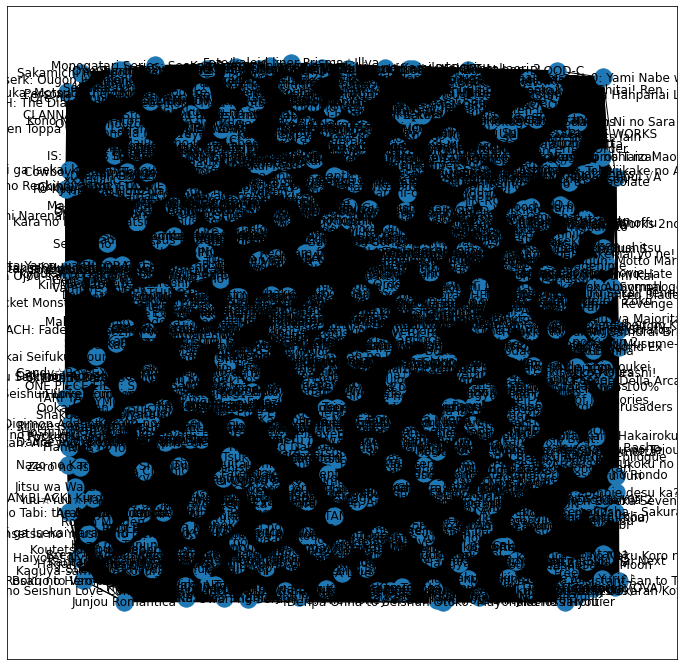

In [27]:
# interactive_network_viz(g, ["name", "edge_count"])

pos = nx.random_layout(g)
plt.figure(3,figsize=(12,12)) 
nx.draw_networkx(g, pos=pos)
plt.show()
# e = nxa.draw_networkx_edges(g, pos=pos)
# n = nxa.draw_networkx_nodes(g, pos=pos)
# n = n.mark_circle(color=node_color, opacity=0.8).encode(
#     size=alt.Size("edge_count:Q", scale=alt.Scale(range=[50, 1000])),
#     tooltip=tool_tip_list
# )
# e = e.mark_line(color=edge_color).encode(
#     strokeWidth=alt.Size("weight:Q", scale=alt.Scale(range=[0.1, 5]), legend=None)
# )
# viz = (e+n).properties(width=800, height=800)